In [103]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
nltk.download('stopwords')
stop_words = stopwords.words('english')
from wordcloud import WordCloud
nltk.download('wordnet')
nltk.download('punkt')
import matplotlib.pyplot as plt
import itertools
import random
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [90]:
df = pd.read_csv('train.dat', delimiter='\t', header=None).drop(columns=[0]).rename(columns={1: "text"})

In [ ]:
def remove_stopwords(token_list):
  stop_words = set(stopwords.words('english'))
  token_text = set(token_list)
  cleaned = list(token_text - stop_words)
  return cleaned

In [116]:
df['lower'] = df['text'].str.lower()
df['no_number'] = df["lower"].str.replace('\d+', ' ', regex=True)
df["clean_text"] = df['no_number'].str.replace('[^\w\s]',' ', regex=True)

df['tokenized_text'] = df['clean_text'].apply(nltk.word_tokenize)
df['no_stopwords'] = df['tokenized_text'].apply(remove_stopwords)
df["combine"] = df["no_stopwords"].str.join(" ")

In [117]:
df.head(5)

,text,lower,no_number,clean_text,tokenized_text,no_stopwords,combine
0,Catheterization laboratory events and hospital...,catheterization laboratory events and hospital...,catheterization laboratory events and hospital...,catheterization laboratory events and hospital...,"[catheterization, laboratory, events, and, hos...","[angioplasty, involving, consecutively, one, p...",angioplasty involving consecutively one patien...
1,Renal abscess in children. Three cases of rena...,renal abscess in children. three cases of rena...,renal abscess in children. three cases of rena...,renal abscess in children three cases of rena...,"[renal, abscess, in, children, three, cases, o...","[reviewed, antibiotics, possible, pediatric, a...",reviewed antibiotics possible pediatric abnorm...
2,Hyperplastic polyps seen at sigmoidoscopy are ...,hyperplastic polyps seen at sigmoidoscopy are ...,hyperplastic polyps seen at sigmoidoscopy are ...,hyperplastic polyps seen at sigmoidoscopy are ...,"[hyperplastic, polyps, seen, at, sigmoidoscopy...","[proximal, undergoing, colonoscopy, one, findi...",proximal undergoing colonoscopy one findings h...
3,Subclavian artery to innominate vein fistula a...,subclavian artery to innominate vein fistula a...,subclavian artery to innominate vein fistula a...,subclavian artery to innominate vein fistula a...,"[subclavian, artery, to, innominate, vein, fis...","[approach, percutaneous, temporary, complicati...",approach percutaneous temporary complication o...
4,Effect of local inhibition of gamma-aminobutyr...,effect of local inhibition of gamma-aminobutyr...,effect of local inhibition of gamma-aminobutyr...,effect of local inhibition of gamma aminobutyr...,"[effect, of, local, inhibition, of, gamma, ami...","[conscious, hr, alanine, studies, rats, pmol, ...",conscious hr alanine studies rats pmol dialysa...


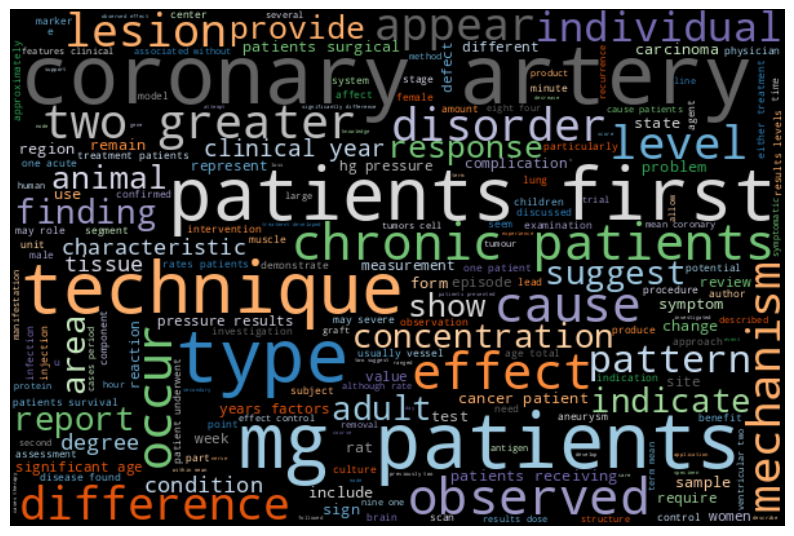

In [118]:
a = " ".join(list(itertools.chain.from_iterable(list(df["no_stopwords"].values))))

cloud=WordCloud(colormap='tab20c',width=600,height=400).generate(a)
fig=plt.figure(figsize=(10,15))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')
plt.show()

In [132]:
entries = list(df["combine"].values)
vectorizer = TfidfVectorizer(max_df=0.3, # drop words that occur in more than 30% the paragraphs
                             min_df=10, # only use words that appear at least five times
                             stop_words='english',
                             lowercase=True, #convert everything to lower case
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

tfidf = vectorizer.fit_transform(entries)

In [133]:
tfidf_csr = tfidf.tocsr()
n = tfidf_csr.shape[0]
# A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names_out()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = tfidf_csr[i, j]

In [141]:
i = 123
print('Original sentence:', entries[i])
print('Tf_idf vector:', dict(sorted(tfidf_bypara[i].items(), key=lambda item: item[1], reverse=True)))

Original sentence: osseointegrated approach longest follow performance edentulous mandible atrophic house tissue supported bone strength simultaneous resorption completely grafts done reconstruction thus sites infection cases rate additional achieved prostheses far implants means possibility performed minimizes oral rehabilitation severely prosthetic procedure simultaneously therefore placement provides reconstructing years presented ability autogenous contamination method patients external implant success negligible
Tf_idf vector: {'minimizes': 0.22138831841716602, 'resorption': 0.20130965927176195, 'negligible': 0.20023672684137975, 'longest': 0.19920429222786817, 'mandible': 0.19820940912375343, 'atrophic': 0.19455648825357388, 'autogenous': 0.1905848499495622, 'contamination': 0.1871173960291045, 'prostheses': 0.18024237059874765, 'implant': 0.1773600998534587, 'implants': 0.17275507348021904, 'strength': 0.17053578114809248, 'rehabilitation': 0.16507849628255805, 'far': 0.16421906

In [136]:
# Getting the word list.
terms = vectorizer.get_feature_names_out()

# Number of topics.
ntopics=10

# Linking words to topics
def word_topic(tfidf,solution, wordlist):

    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)

    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str)
        topwords.loc[column]=[x for x in chosenlist]
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 10

In [137]:
# LSA

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
paras_lsa = lsa.fit_transform(tfidf)

components_lsa = word_topic(tfidf, paras_lsa, terms)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)


<ipython-input-136-5148ea42f7dd>:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  topwords=pd.Series(index=index)


In [138]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=ntopics,
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

paras_lda = lda.fit_transform(tfidf)

components_lda = word_topic(tfidf, paras_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)


<ipython-input-136-5148ea42f7dd>:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  topwords=pd.Series(index=index)


In [139]:
# NNMF

from sklearn.decomposition import NMF

nmf = NMF(init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics,
          random_state=0,
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
paras_nmf = nmf.fit_transform(tfidf)

components_nmf = word_topic(tfidf, paras_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
<ipython-input-136-5148ea42f7dd>:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  topwords=pd.Series(index=index)


In [140]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
                  LSA              LDA               NNMF
0        study 157.09     patient 3.16           age 4.14
0      disease 146.73        case 2.95         study 3.42
0      patient 145.07     disease 2.91         years 3.41
0    treatment 144.03       study 2.89          risk 3.33
0      results 139.52   treatment 2.83  significantly 2.9
0      clinical 135.3  associated 2.68         group 2.87
0   associated 129.13    clinical 2.63      compared 2.87
0        years 124.56        cases 2.6       disease 2.77
0  significant 123.84     results 2.52   significant 2.68
0        group 120.29      report 2.48       factors 2.57
Topic 1:
                  LSA              LDA             NNMF
1  significantly 37.1     patient 4.25        case 9.07
1      pressure 33.78   treatment 3.79      report 7.15
1        effect 29.85     disease 3.68         old 6.02
1       effects 29.61       study 3.51        year 5.41
1         blood 28.81        case 3.37     patient 4.86
1     in